In [1]:
!pip install pydsstools

In [1]:
import os
from pydsstools.heclib.dss.HecDss import Open

from datetime import datetime
from pydsstools.heclib.dss import HecDss
from pydsstools.core import TimeSeriesContainer, UNDEFINED
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import subprocess


# Hidrogramas

In [2]:
def hidrogramas_data_plot(main_path, filename, station, label_path, return_period):
    
    labels_station = pd.read_csv(label_path)
    
    station_label = labels_station[labels_station['ELEM__HMS'] == station].values[0][0]
    main_path_dss          = os.path.join(main_path,'01_Escenarios_DSS',f'TR{return_period}')
    output_df_escenarios   = os.path.join(main_path,'02_Hidrogramas') 
    output_plot_escenarios = os.path.join(main_path,'03_Hidrogramas_plot')                                         

    date = pd.date_range('2015-02-01 01:00:00','2015-02-05 13:00:00',freq='15min')
    date_min = np.arange(0, len(date)/4, 0.25)
    data_escenarios = pd.DataFrame({'datetime':date}) 
    data_escenarios = data_escenarios.set_index('datetime')
    
    os.chdir(main_path_dss)
                                          
    fig, ax1 = plt.subplots(figsize=(9,6))
    
    files = [f'{filename}{i}.dss' for i in range(1,51)] 
    for i,file in enumerate(files):
        dss_file =file
        pathname  = f"//{station}/FLOW//15MIN/RUN:RUN 1/"
        startDate = "01FEB2015 01:00:00"
        endDate   = "05FEB2015 13:00:00"

        fid = HecDss.Open(dss_file)
        ts  = fid.read_ts(pathname, window=(startDate,endDate), regular=True,trim_missing=False)

        times  = np.array(ts.pytimes)
        values = ts.values 
        data_escenarios[f'Esc_{i+1}'] = values 
        if max(values) > 0:
            ax1.plot(date_min, values, color='black', linestyle=':')
        else:
            continue
    
    
    maximos = np.array(data_escenarios.max())
    maximos_val = maximos.max()
    maximo_mayor0      = maximos[np.where(data_escenarios.max()>0)]
    maximo_mayor0_mean = maximo_mayor0.mean()
    maximo_mayor0_std  = maximo_mayor0.std()

    maximo_mean_arr   = np.tile(maximo_mayor0_mean,len(date_min))
    maximo_std_thres_up   = np.tile(maximo_mayor0_mean,len(date_min))+maximo_mayor0_std
    maximo_std_thres_down = np.tile(maximo_mayor0_mean,len(date_min))-maximo_mayor0_std
    
    if maximo_std_thres_down[0] < 0:
        maximo_std_thres_down = 0 #maximo_std_thres_down*(-1)  
        maximo_std_thres_down = np.tile(0,len(date_min))
        
    ax1.plot(date_min, maximo_mean_arr, color='C3', linestyle='-.', label='Media')
    ax1.plot(date_min, maximo_std_thres_up, color='C0', linestyle=':', label='Desviación Estandar')    
    ax1.plot(date_min, maximo_std_thres_down, color='C0', linestyle=':') 
    
    
    plt.title(f'Tr={return_period} Años ({station_label})', fontsize=14, weight='bold')
    ax1.set_xlim([0, 50])
    ax1.set_xlabel("Tiempo (Hrs)",fontsize = 12)
    ax1.set_ylabel("Caudal ($m^{3}$/s)",fontsize = 12)    
    
    for ax in [ax1]: 
        for label in (ax.get_xticklabels()):
            label.set_fontsize(11)

    for ax in [ax1]: 
        for label in (ax.get_yticklabels()):
            label.set_fontsize(11)
    
    ax1.legend()
    ax1.tick_params(axis='both', which='major', pad=12) 

    
    isExist_df   = os.path.exists(output_df_escenarios)  
    isExist_plot = os.path.exists(output_plot_escenarios)
    
    if isExist_df == False:
        os.makedirs(output_df_escenarios, exist_ok=True)
    if isExist_plot == False:
        os.makedirs(output_plot_escenarios, exist_ok=True)

    os.chdir(output_df_escenarios)   
    data_escenarios.to_csv(f'{station_label}_TR{return_period}_Hidrograma.csv', encoding='latin8')

    os.chdir(output_plot_escenarios)   
    fig.savefig(f'{station_label}_TR{return_period}_Hidrograma.png', bbox_inches='tight', dpi=300)
    plt.close(fig)

    escenario_max = data_escenarios.max().sort_values(ascending=False).index[0]
    
    max_excenario = np.array(data_escenarios[f'{escenario_max}'])
    return station_label, max_excenario, maximos_val, maximo_mayor0_mean, maximo_mayor0_std, date_min, escenario_max
                                          

In [3]:
def maximum_flow_per_return_period(main_path, filename, station, label_path, return_periods):
    
    return_periods_columns = [f'TR={i}' for i in return_periods]
    data_returns_periods_max     = pd.DataFrame(columns=return_periods_columns)
    data_returns_periods_max_std = pd.DataFrame(columns=return_periods_columns)
    
    
    fig, ax2 = plt.subplots(figsize=(9,6))
    colors = ['C0','C1','C2','C3','C4','C5']
    for i,return_period in enumerate(return_periods):
        station_label, data_max_RT, max_RT, mean_RT, std_RT, date_min,escenario_max = hidrogramas_data_plot(main_path,
                                                                                                            filename,
                                                                                                            station, 
                                                                                                            label_path, 
                                                                                                            return_period, 
                                                                                                            )
        
        data_returns_periods_max[f'TR={return_period}']     = data_max_RT
        data_returns_periods_max_std[f'TR={return_period}'] = [round(max_RT,2), round(mean_RT,2), round(std_RT,2),escenario_max]
        
    
        ax2.plot(date_min, data_max_RT, linestyle='--', label=f'TR={return_period} Años', color=colors[i])
        ax2.plot(date_min, np.tile(mean_RT,len(date_min)), linestyle='-', 
                 label=f'Med TR={return_period}', color=colors[i])
     
    plt.title(f'Hidrograma de Salida ({station_label})', fontsize=14, weight='bold')
    ax2.set_xlim([0, 50])
    ax2.set_xlabel("Tiempo (Hrs)",fontsize = 12)
    ax2.set_ylabel("Caudal ($m^{3}$/s)",fontsize = 12)    
    
    for ax in [ax2]: 
        for label in (ax.get_xticklabels()):
            label.set_fontsize(11)

    for ax in [ax2]: 
        for label in (ax.get_yticklabels()):
            label.set_fontsize(11)
    
    ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
          fancybox=False, shadow=False, ncol=5, fontsize=10)
    ax2.tick_params(axis='both', which='major', pad=12)         
      
    # Indexes   
    date = pd.date_range('2015-02-01 01:00:00','2015-02-05 13:00:00',freq='15min')    
    data_returns_periods_max = data_returns_periods_max.set_index(date)
    data_returns_periods_max.index.name = 'datetime'
    
    index_parameters = pd.Series(['Caudal Maximo (m3/s)','Caudal Maximo promedio (m3/s)',
                                  'Desviación Estandar (m3/s)', 'Escenario_max'])
    data_returns_periods_max_std = data_returns_periods_max_std.set_index(index_parameters)
    data_returns_periods_max_std.index.name = 'parameters'
    
    output_df_max_flow   = os.path.join(main_path,'04_Max_Caudales') 
    output_plot_max_flow = os.path.join(main_path,'05_Max_Caudales_plot')     

    isExist_df   = os.path.exists(output_df_max_flow)  
    isExist_plot = os.path.exists(output_plot_max_flow)

    if isExist_df == False:
        os.makedirs(output_df_max_flow, exist_ok=True)
    if isExist_plot == False:
        os.makedirs(output_plot_max_flow, exist_ok=True)
                
    os.chdir(output_df_max_flow)
    data_returns_periods_max.to_csv(f'{station_label}_max_caudal_Ts.csv', encoding='latin8')
    data_returns_periods_max_std.T.round(2).to_csv(f'{station_label}_max_caudal_Ts_parameters.csv', encoding='latin8')
    
    os.chdir(output_plot_max_flow)
    fig.savefig(f'{station_label}_caudales_maximos.png', bbox_inches='tight', dpi=300)
    #plt.close(fig)
    
    print('-----------------------')
    print('Processing...')
    print('Done: ', station, 'as', station_label)
    print('-----------------------')

    

## VARIABLES
- main_path : carpeta con los archivos dss
- filename: nombre archivo dss
- station : nombre estacion objetivo
- label_path : archivo csv con las ids y nombres de las estaciones
- return_periods :  periodos de retorno

-----------------------
Processing...
Done:  J4220 as EST-1
-----------------------


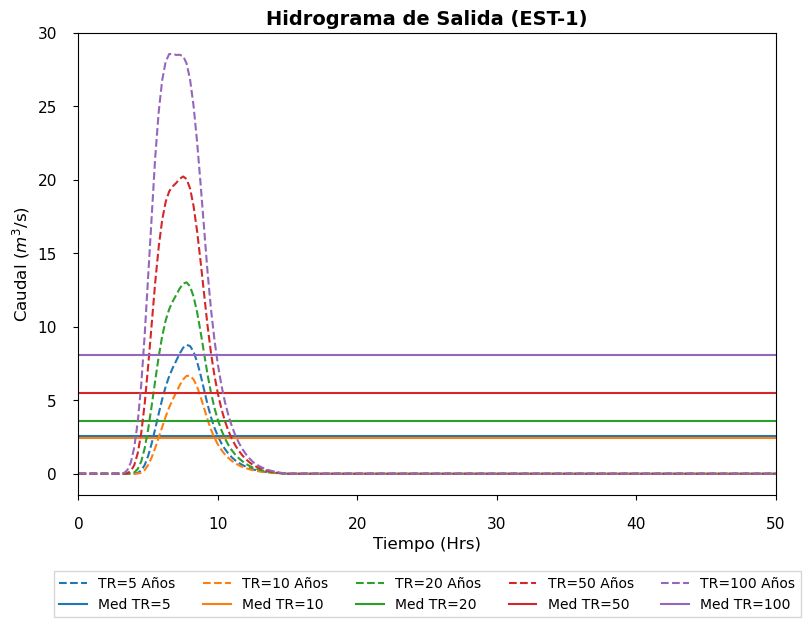

In [6]:
main_path   = r"D:\00_HIDROGRAMAS"
station     = 'J4220'
label_path  = r"D:\00_HIDROGRAMAS\labels.csv"
filename    = 'Rochault'
return_periods = [5, 10, 20, 50, 100]

maximum_flow_per_return_period(main_path, filename, station, label_path, return_periods)

-----------------------
Processing...
Done:  J3656 as DET-1
-----------------------


C:\Users\Carolina\AppData\Local\Temp\ipykernel_15768\140013052.py:41: RuntimeWarning: Mean of empty slice.
  maximo_mayor0_mean = maximo_mayor0.mean()
C:\Users\Carolina\anaconda3\envs\py310\Lib\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\Carolina\anaconda3\envs\py310\Lib\site-packages\numpy\core\_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\Carolina\anaconda3\envs\py310\Lib\site-packages\numpy\core\_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
C:\Users\Carolina\anaconda3\envs\py310\Lib\site-packages\numpy\core\_methods.py:198: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


-----------------------
Processing...
Done:  J3618 as DET-2
-----------------------
-----------------------
Processing...
Done:  J3674 as DET-3
-----------------------
-----------------------
Processing...
Done:  J3671 as DET-4
-----------------------
-----------------------
Processing...
Done:  J3633 as DET-5
-----------------------
-----------------------
Processing...
Done:  W13870 as DET-6
-----------------------
-----------------------
Processing...
Done:  W14100 as DET-7
-----------------------
-----------------------
Processing...
Done:  J3682 as DET-8
-----------------------
-----------------------
Processing...
Done:  J3627 as DET-9
-----------------------
-----------------------
Processing...
Done:  J3650 as DET-10
-----------------------
-----------------------
Processing...
Done:  J3641 as DET-11
-----------------------


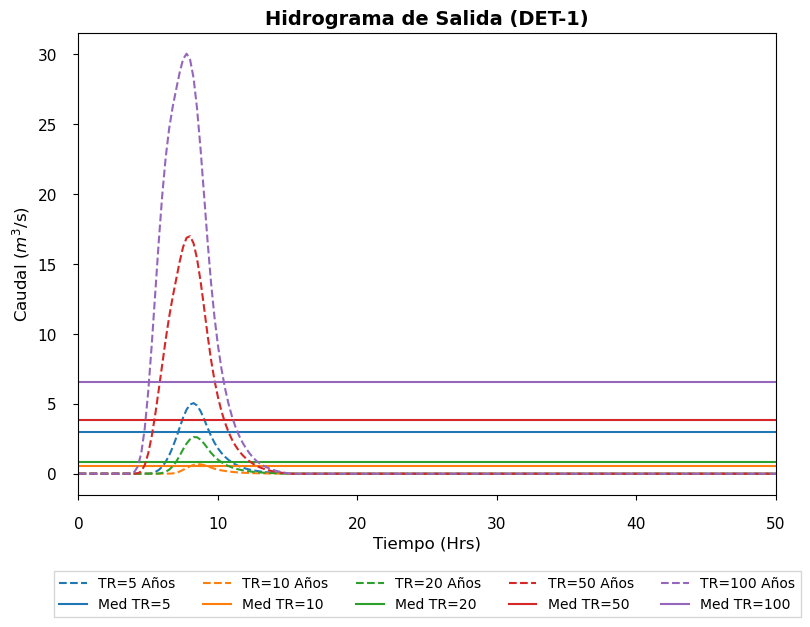

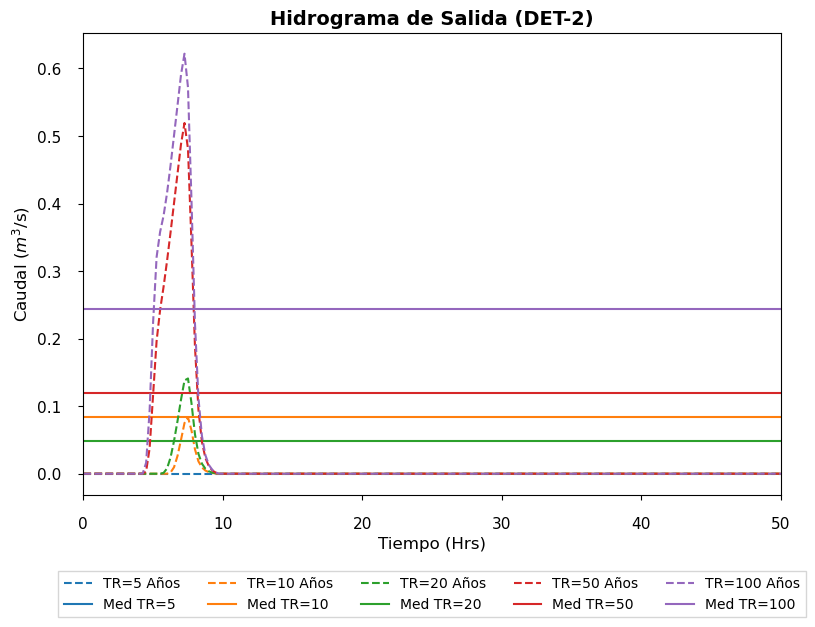

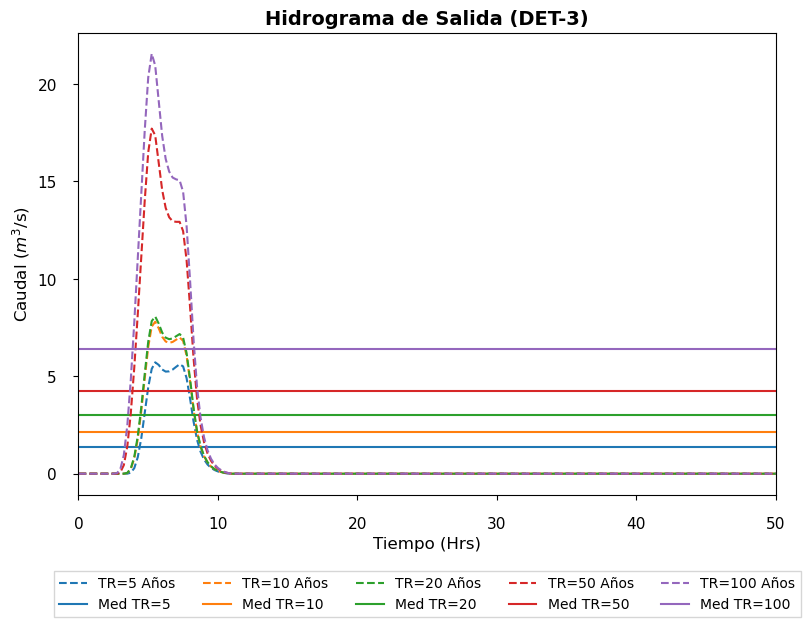

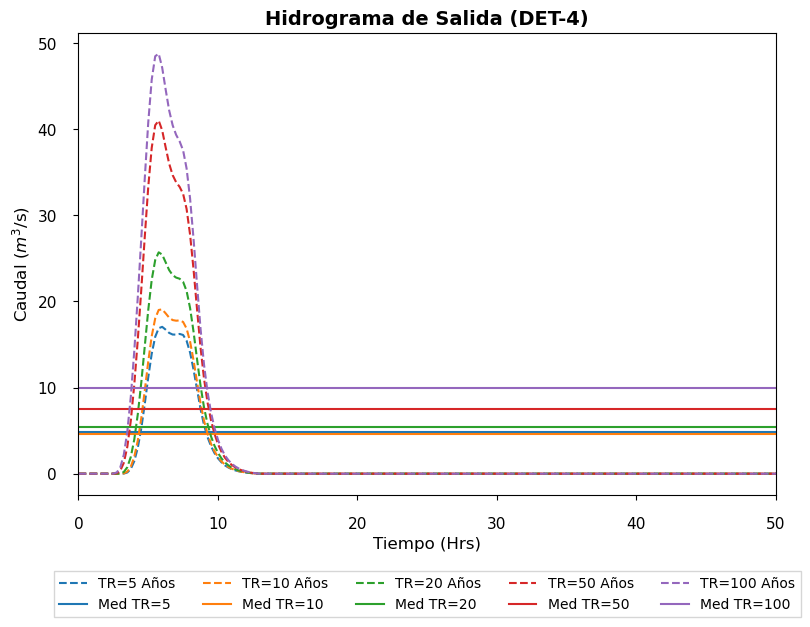

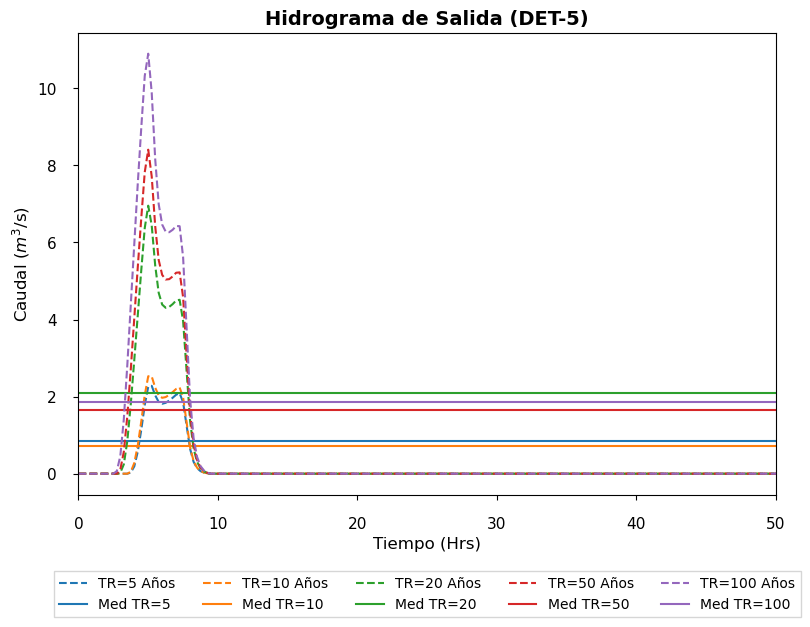

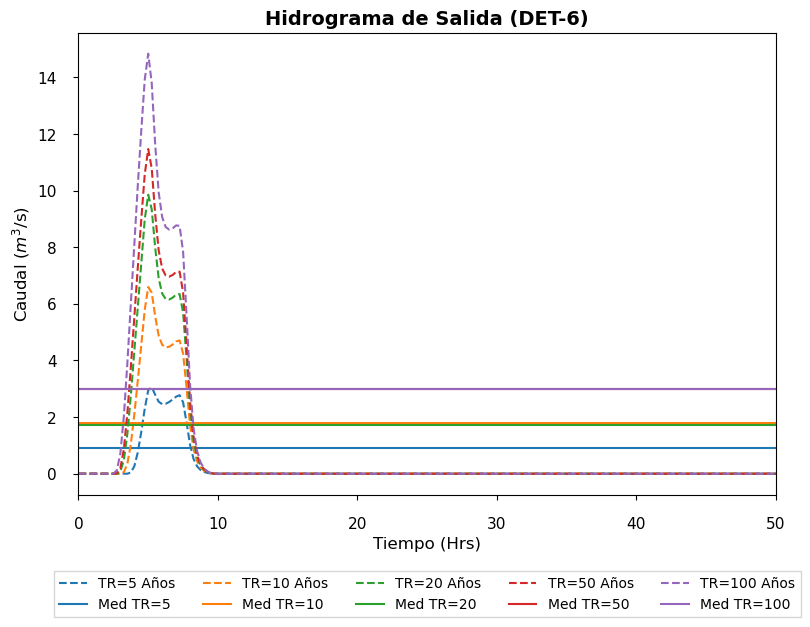

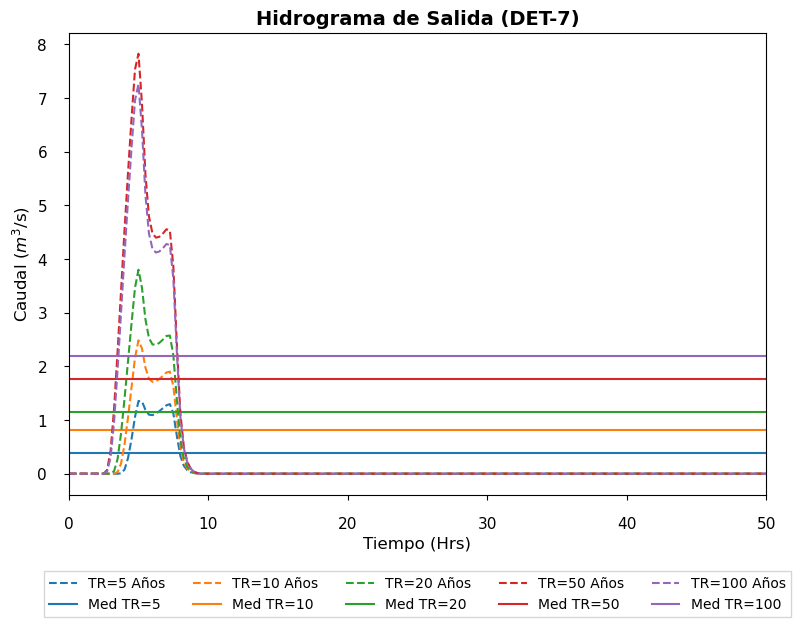

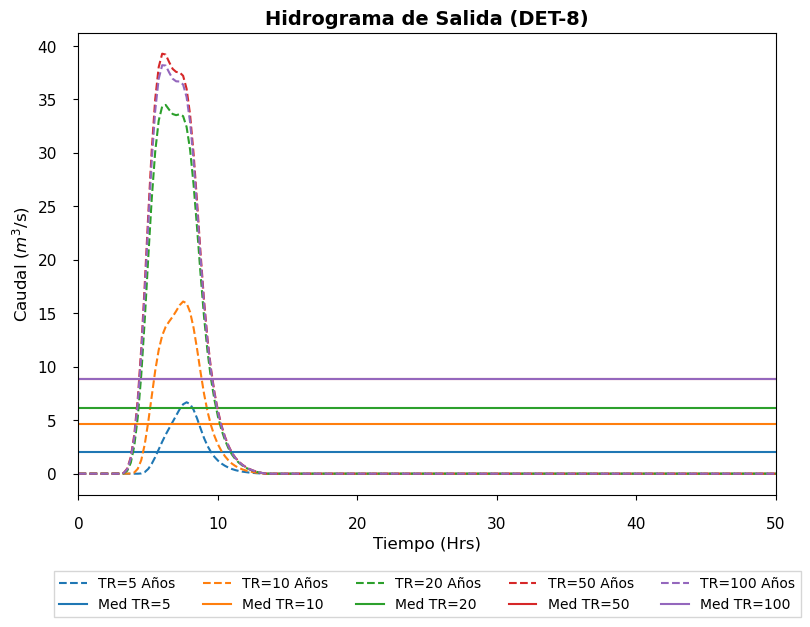

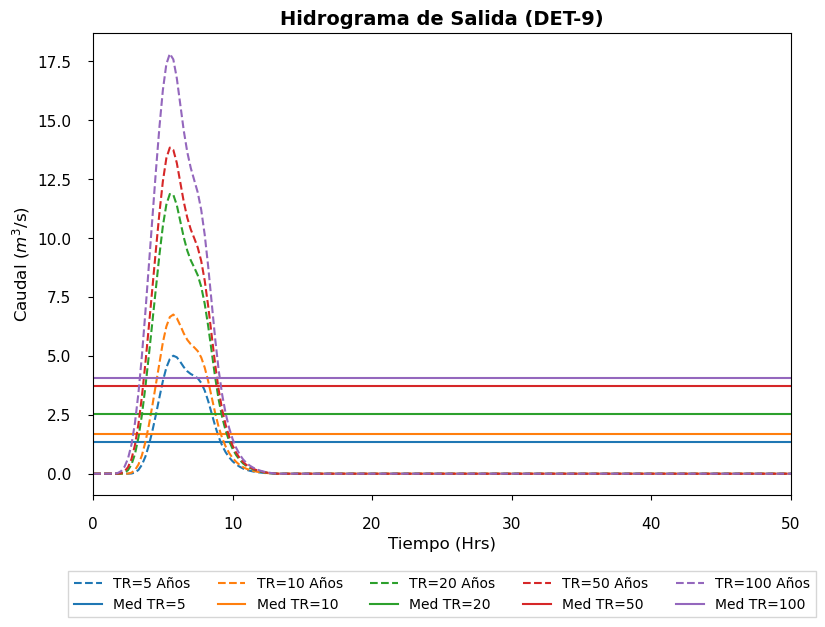

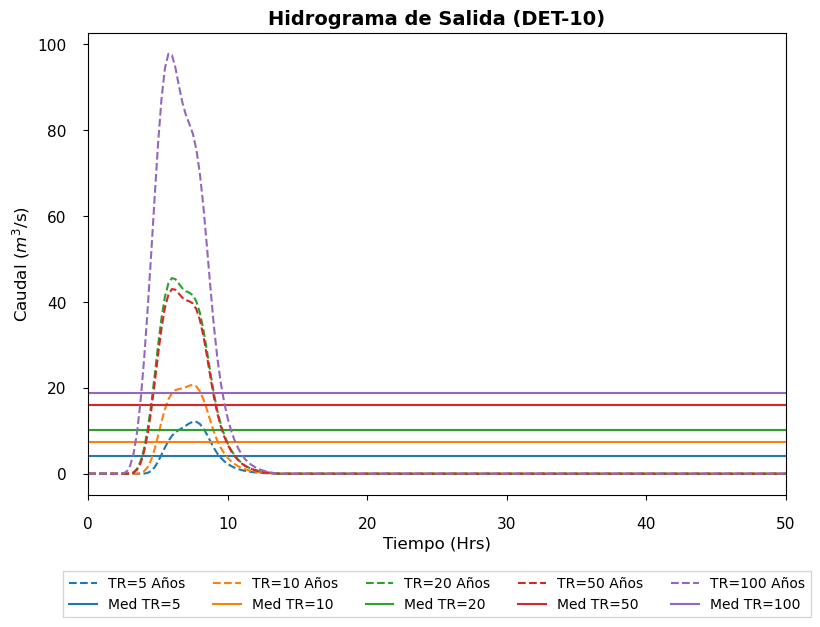

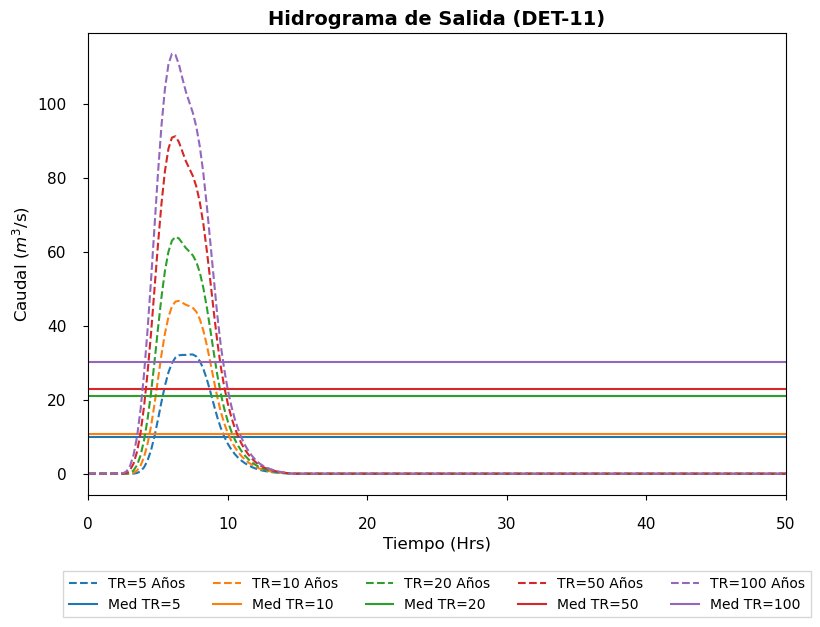

In [8]:
main_path   = r"D:\00_HIDROGRAMAS"
station     = 'J4220'
label_path  = r"D:\00_HIDROGRAMAS\labels.csv"
stations = ['J3656','J3618','J3674','J3671','J3633','W13870','W14100','J3682','J3627','J3650','J3641']
return_periods = [5, 10, 20, 50, 100]


for station in stations:
    maximum_flow_per_return_period(main_path, filename, station, label_path, return_periods)